In [1]:
import json
import pickle

import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from tqdm import tqdm

import tools.utils as utils
import tools.data_generation as dg
import tools.points_processing as pp

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Conv1D, Flatten, MaxPool1D, Dropout, GlobalMaxPool1D
from keras.metrics import binary_accuracy, binary_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight

# from xgboost import XGBClassifier

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [28]:
def normalize(data):
    """
    Normalizes the data in a fancy-ish way. Assumes the features are: lowT, upT, sonic1, sonic2, sonic3, lwc.
    """
    temperature, wind, other = np.split(data, [2,5], axis=2)
    
    temperature = temperature - temperature[:,0:1,:]
    mu = wind.mean((0,1), keepdims=True)
    std = wind.std((0,1), keepdims=True)
    wind = (wind - mu) / std
    # LWC and angles doesn't need normalization
    
    data = np.concatenate((temperature, wind, other), axis=2)
    
    return data

In [2]:
with open('data/data16.pickle', 'rb') as f:
    data = pickle.load(f)

df = dg.get_df(data)
df_points = pp.prepare_points()

df = dg.add_labels(df, df_points)

df = dg.add_angles(df)

In [3]:
features = ['lowT_av', 'upT_av', 'sonic1', 'sonic2', 'sonic3', 'lwc1V_av', 'theta', 'phi']

In [5]:
pos_time, pos_features = dg.generate_positive(df, 
                                              size=10, 
                                              feature_names=features, 
                                              label_name='low_label')
print(pos_features.shape)

100%|██████████████████████████████████████████████████████████████████████| 791858/791858 [00:01<00:00, 580912.45it/s]


(2937, 10, 8)


In [19]:
START = 800000
END   = 7500000
neg_time, neg_features = dg.generate_negative(df[(df.time >= START) & (df.time < END)], 
                                              size=10,
                                              safe=50,
                                              feature_names=features,
                                              label_name='low_label')

print(neg_features.shape)

100%|██████████████████████████████████████████████████████████████████████| 670000/670000 [00:02<00:00, 328443.70it/s]


(12987, 10, 8)


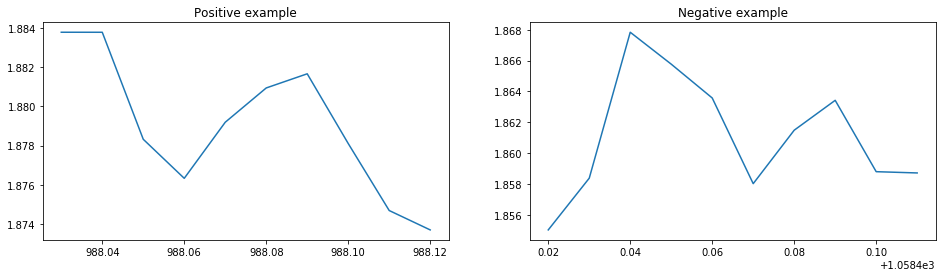

In [20]:
plt.rcParams['figure.figsize'] = [16, 4]

idx = 121

plt.subplot(121)
plt.plot(pos_time[idx]/1000., pos_features[idx,:,6])
plt.title("Positive example")

idx = 485

plt.subplot(122)
plt.plot(neg_time[idx]/1000., neg_features[idx,:,6])
plt.title("Negative example")
plt.show()

In [21]:
pos_labels = np.ones(pos_features.shape[0])
neg_labels = np.zeros(neg_features.shape[0])

In [22]:
print(pos_features.shape)
print(neg_features.shape)

(2937, 10, 8)
(12987, 10, 8)


In [23]:
print(pos_labels.shape)
print(neg_labels.shape)

(2937,)
(12987,)


In [24]:
X_data = np.concatenate((pos_features, neg_features))
Y_data = np.concatenate((pos_labels, neg_labels))

In [25]:
X_data.shape

(15924, 10, 8)

In [29]:
X_data_norm = normalize(X_data)

#X_data_norm = X_data_norm[:,:,0:1]

In [30]:
X_data_norm.shape

(15924, 10, 8)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data_norm, Y_data, test_size=.1, random_state=0)

print(X_train.shape)
print(X_test.shape)

(14331, 10, 8)
(1593, 10, 8)


In [32]:
inp_shape = X_train.shape[1:]

In [144]:
inputs = Input(shape=inp_shape)
X = Conv1D(20, 3, activation='relu')(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.7)(X)

X = Conv1D(40, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.7)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.7)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.7)(X)

X = Flatten()(X)
X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 18, 20)            80        
_________________________________________________________________
dropout_68 (Dropout)         (None, 18, 20)            0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 16, 40)            2440      
_________________________________________________________________
dropout_69 (Dropout)         (None, 16, 40)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 14, 50)            6050      
_________________________________________________________________
dropout_70 (Dropout)         (None, 14, 50)            0         
__________

In [33]:
inputs = Input(shape=inp_shape)
X = LSTM(20, return_sequences=True)(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = LSTM(50, return_sequences=True)(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = LSTM(30, return_sequences=False)(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 20)            2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
__________

In [34]:
model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])

In [35]:
weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

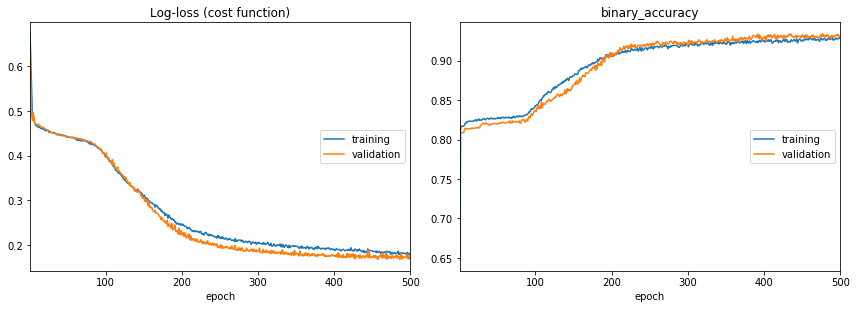

In [36]:
history = model.fit(X_train, Y_train, 
                    epochs=500, 
                    batch_size=4000, 
                    class_weight=weight, 
                    validation_data=(X_test, Y_test), 
                    verbose=0,
                    callbacks=[PlotLossesKeras()])

In [38]:
print(model.evaluate(X_train, Y_train, batch_size=4000))
print(model.evaluate(X_test, Y_test, batch_size=4000))

14331/14331 [==============================] - 0s 12us/step
[0.15828527575776613, 0.93531504786444608]
1593/1593 [==============================] - 0s 14us/step
[0.17254486680030823, 0.92969238758087158]


In [39]:
utils.write_report(model, X_train, Y_train, X_test, Y_test, keras=True, threshold=.5)

Training data (less important):
 Accuracy: 0.93532
 Precision: 0.84196
 Recall: 0.79749
  F1 score (class 1): 0.81912
 F1 score (class 0): 0.96062
Test data (more important):
 Accuracy: 0.92969
 Precision: 0.84588
 Recall: 0.77377
  F1 score (class 1): 0.80822
 F1 score (class 0): 0.95696
